In [1]:
from jeroHelper.setupUtils import append_deepfinder_path, get_tomo_indices, PARENT_PATH
append_deepfinder_path()

from jeroHelper.trainHelper import make_trainer
from jeroHelper.coordGen import OLMaker
from jeroHelper.showcaseResults import (predict_fullTomogram, load_model, load_tomoData,
                                        fullTomogram_modelComparison, make_comparison_plot, write_comparison_gif)

from deepfinder.training_pylit import Train, TrainPretext
from deepfinder.utils.common import read_array
import deepfinder.utils.objl as ol
from deepfinder.model_pylit import PretextDeepFinder_model

import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import mrcfile
import pandas as pd

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [14]:
train_tomos = ['tomo02', 'tomo03', 'tomo04', 'tomo17']
concat_train_ids = sorted([s.replace('tomo', '') for s in train_tomos])
concat_train_ids = '-'.join(concat_train_ids)

val_tomos = ['tomo32', 'tomo10']
concat_val_ids = sorted([s.replace('tomo', '') for s in val_tomos])
concat_val_ids = '-'.join(concat_val_ids)

test_tomos = ['tomo38']

objectList_maker = OLMaker(train_tomos, val_tomos, test_tomos, 12, 15, 20, None, None)
objectList_maker.make_xml_objlists(overwrite=False)
objlist_train, objlist_val = ol.read_xml(objectList_maker.train_objlist_path), ol.read_xml(objectList_maker.val_objlist_path)

Pairs of tomo IDs to indices:
[('tomo02_patch000', 0), ('tomo02_patch001', 1), ('tomo02_patch002', 2), ('tomo02_patch003', 3), ('tomo02_patch004', 4), ('tomo02_patch005', 5), ('tomo02_patch006', 6), ('tomo02_patch020', 7), ('tomo02_patch021', 8), ('tomo02_patch030', 9), ('tomo03_patch000', 10), ('tomo03_patch002', 11), ('tomo03_patch004', 12), ('tomo03_patch006', 13), ('tomo03_patch008', 14), ('tomo03_patch010', 15), ('tomo03_patch020', 16), ('tomo03_patch021', 17), ('tomo03_patch022', 18), ('tomo03_patch030', 19), ('tomo03_patch031', 20), ('tomo03_patch032', 21), ('tomo04_patch000', 22), ('tomo04_patch002', 23), ('tomo04_patch004', 24), ('tomo04_patch006', 25), ('tomo04_patch008', 26), ('tomo04_patch009', 27), ('tomo04_patch020', 28), ('tomo04_patch021', 29), ('tomo04_patch030', 30), ('tomo10_patch001', 31), ('tomo10_patch002', 32), ('tomo10_patch003', 33), ('tomo10_patch009', 34), ('tomo10_patch010', 35), ('tomo10_patch011', 36), ('tomo10_patch020', 37), ('tomo10_patch030', 38), ('to

In [15]:
patch_to_overfit = [{'tomo_idx': 0,
 'obj_id': 0,
 'label': 0,
 'x': 79.0,
 'y': 79.0,
 'z': 79.0,
 'psi': None,
 'phi': None,
 'the': None,
 'cluster_size': None}]

val_patch = [{'tomo_idx': 49,
  'obj_id': 0,
  'label': 1,
  'x': 79.0,
  'y': 79.0,
  'z': 79.0,
  'psi': None,
  'phi': None,
  'the': None,
  'cluster_size': None}]

In [4]:
dim_in = 56
lr = 1e-4
tb_logdir = './scratchpad_logs/2.10.1_sanity_checks_random_reconstruction/'
batch_size = 32
epochs = 600

myTrainer = TrainPretext(dim_in=dim_in, lr=lr, weight_decay=0.0, tensorboard_logdir=tb_logdir, model_name='2.10_reconstructionModel', mask_pct=0.3)
myTrainer.batch_size = batch_size
myTrainer.flag_direct_read = False
myTrainer.epochs = epochs

In [6]:
myTrainer.launch(objectList_maker.path_data[0:1], objectList_maker.path_target[0:1], patch_to_overfit, patch_to_overfit)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
Set SLURM handle signals.

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layer1  | Sequential | 28.6 K
2 | layer2  | Sequential | 103 K 
3 | layer3  | Sequential | 558 K 
4 | layer4  | Sequential | 288 K 
5 | layer5  | Sequential | 96.9 K
---------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.303     Total estimated model params size (MB)


"loss_fn":      MSELoss()
"lr":           0.0001
"weight_decay": 0.0
Saving model at:  /home/haicu/jeronimo.carvajal/Thesis/models/2.10_reconstructionModel_ep600_in56_lr0.000100_v3.model


In [7]:
def load_model(model_file, weight_decay=0):
    "Loads a saved model file by loading the state dictionary."
    aux_train_vals = model_file.split('/')[-1]
    lr = aux_train_vals.split('lr')[-1].split('_')[0]
    lr = float(lr)

    model = PretextDeepFinder_model(torch.nn.MSELoss(), lr, weight_decay)
    model.load_state_dict(torch.load(model_file))
    
    gpu_model = torch.nn.DataParallel(model)
    gpu_model.cuda()
    
    return gpu_model

In [8]:
model_file = '/home/haicu/jeronimo.carvajal/Thesis/models/2.10_reconstructionModel_ep600_in56_lr0.000100_v2.model'
aux_idx = patch_to_overfit[0]['tomo_idx']

tomo_file = objectList_maker.path_data[aux_idx]
label_file = objectList_maker.path_target[aux_idx]

model = load_model(model_file)
tomo_data, label_data = load_tomoData(tomo_file, label_file)

Tomogram shape:  (160, 160, 160)


In [9]:
def predict_fullTomogram(tomogram_data, model, dim_in, n_centers, Nclass):
    """Predict a full tomogram.
    
    First load all necessary data, then set up evenly spaced centers along the tomogram to make overlapping patches to make predictions.

    The full tomogram predicted values are the average prediction of the overlapping model outputs for each patch.
    """
    
    zyx = tomogram_data.shape # tomogram dimensions
    ref_dim = max(zyx)
    l = int(dim_in/2) # size from center

    pcenters = []
    overlaps = []
    for i in zyx:

        factor = i/ref_dim
        new_n_centers = int(np.round(factor*n_centers))
        new_n_centers = max([2, new_n_centers])
        pcenter = np.linspace(l, i-l, new_n_centers, dtype=int)
        
        pcenters.append(pcenter)
        overlaps.append(pcenter[0] - pcenter[1] + 2*l)

    # Assert that the whole tomogram is covered and there is at least some overlapping.
    # Z, Y, X
    if all(np.array(overlaps)>l):
        print(overlaps)
        raise ValueError("There is too much overlap between patches. Reduce the number of centers.")

    if not any(np.array(overlaps)>0):
        print(overlaps)
        raise ValueError('Current patches do not cover the full tomogram. Specify a larger number of centers.')
    
    z, y, x = zyx

    pred_tomo = torch.zeros((1, Nclass, z, y, x)).detach()
    count_tensor = torch.zeros((1, Nclass, z, y, x)).detach() # for average normalization of overlapping patches

    total_iterations = len(pcenters[0])*len(pcenters[1])*len(pcenters[2])
    
    print('Predicting full tomogram using %i centers...' %n_centers)
    with tqdm(total=total_iterations) as pbar:
        for i in pcenters[0]:
            for j in pcenters[1]:
                for k in pcenters[2]:
                    patch = tomogram_data[i-l:i+l, j-l:j+l, k-l:k+l]
                    patch = torch.as_tensor(patch).unsqueeze(0).unsqueeze(0).to("cuda")
                    
                    model.eval()
                    with torch.no_grad():
                        pred_patch = model(patch)
                        pred_patch = pred_patch.to("cpu")

                    pred_tomo[:, :, i-l:i+l, j-l:j+l, k-l:k+l] += pred_patch
                    count_tensor[:, :, i-l:i+l, j-l:j+l, k-l:k+l] += 1
                    pbar.update(1)
    
    # Get average predictions for overlapping patches
    pred_tomo = pred_tomo/count_tensor

    # print(pred_tomo.shape)
    
    class_pred = pred_tomo[:, 0:2, :, :, :].squeeze().argmax(0).numpy()

    # print(class1_pred.shape)
    
    return class_pred


In [16]:
from deepfinder.dataloader_pylit import PretextDeepFinder_dataset, DataLoader

train_set = PretextDeepFinder_dataset(False, objectList_maker.path_data, objectList_maker.path_target, objlist_train, 
                                      dim_in, 0, None, 0.4)

In [23]:
data, target = train_set[0]
prediction = model(data.unsqueeze(0)).squeeze().cpu().detach().numpy()
data, target = data.squeeze(), target.squeeze()

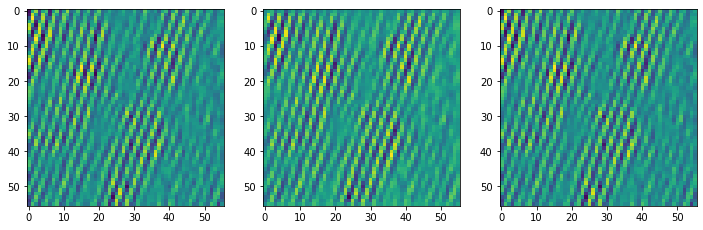

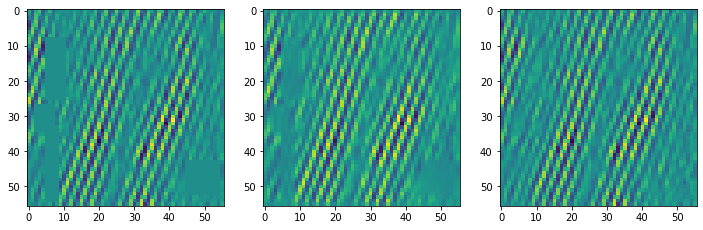

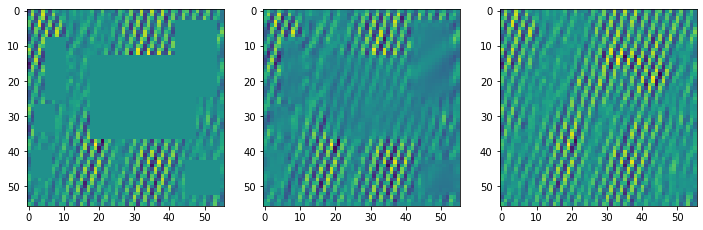

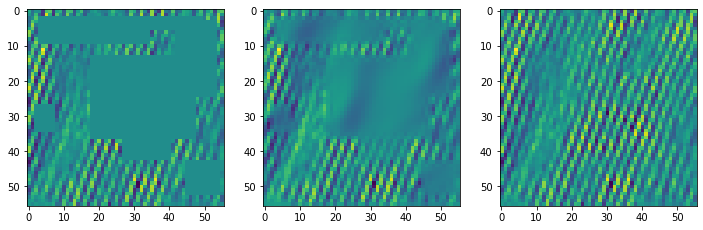

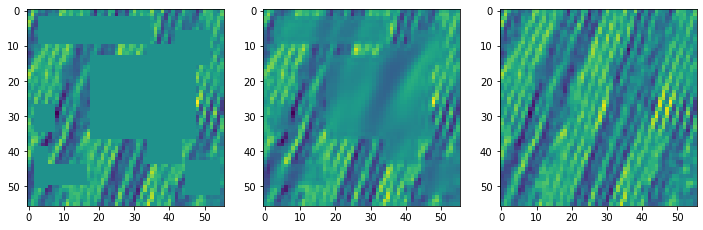

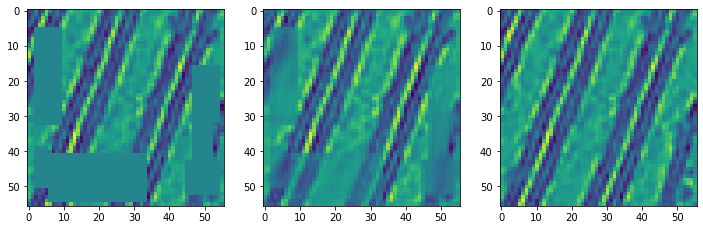

In [22]:
for idx_z in range(0, 56, 10):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 10))
    ax1.imshow(data[idx_z])
    ax2.imshow(prediction[idx_z])
    ax3.imshow(target[idx_z])
    plt.show()

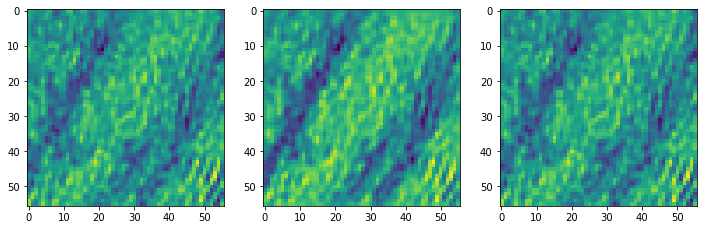

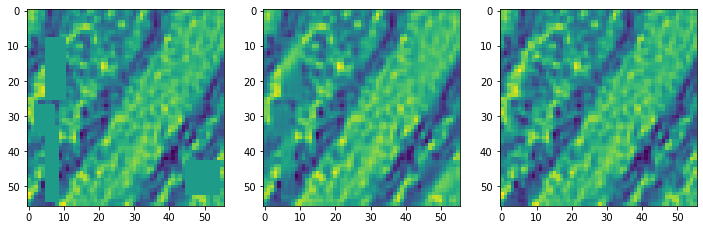

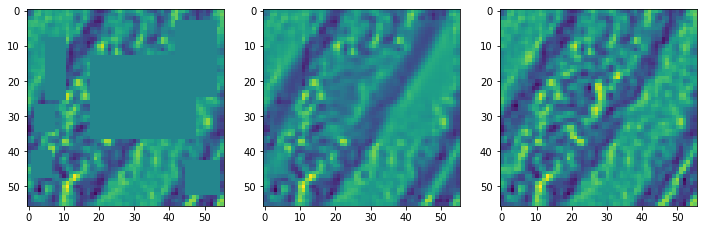

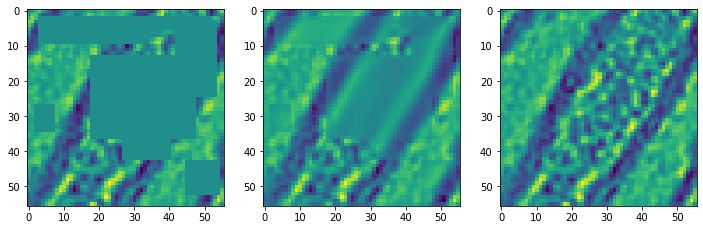

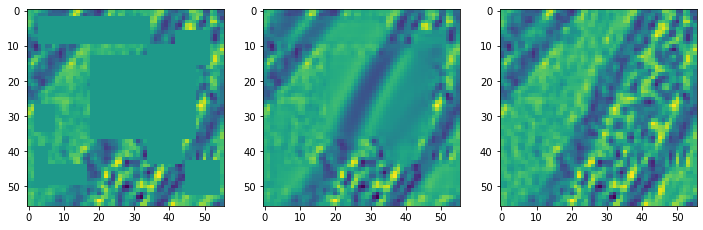

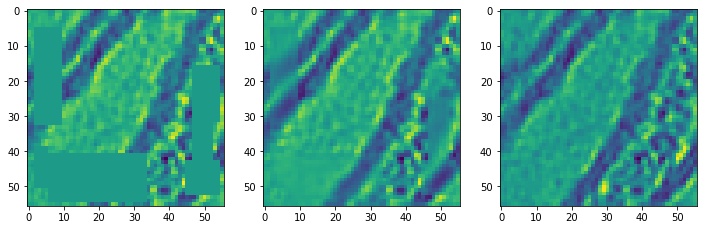

In [12]:
for idx_z in range(0, 56, 10):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 10))
    ax1.imshow(data[idx_z])
    ax2.imshow(prediction[idx_z])
    ax3.imshow(target[idx_z])
    plt.show()